In [151]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

### Utilitiy functions

In [152]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
            b = tf.get_variable(bn)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn)
        b = tf.get_variable(bn)
    return [w,b]

def log_prob(p, s):
    return tf.log(tf.clip_by_value(s*p+(1.0-s)*(1.0-p), eps, 1-eps))

def det_pass(inputs, layer, n=1):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
        inputs = z
    z = add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid)
    z = z*tf.tile(y_,[n,1])+(1-z)*(1-tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.tile(-y_expect-eps, [n,1]), 1, keep_dims=True)

### Parameters

In [153]:
batch_size = 10
ns = 2
lr = 1e-3
eps = 1e-7
alpha = 0.9
steps = 50000
nh = 100

### Sigmoid belief networks

In [154]:
x = tf.placeholder(tf.float32, [None, 392])
h = add_layer(x, "wxh", "bxh", 392, nh, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), [ns*batch_size, nh]))
h2 = add_layer(sh, "whh", "bhh", nh, nh, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns), [ns*ns*batch_size, nh]))
y = add_layer(sh2, "why", "bhy", nh, 392, tf.nn.sigmoid)
y_ = tf.placeholder(tf.float32, [None, 392])

yy = y*tf.tile(y_,[ns**2,1])+(1-y)*(1-tf.tile(y_,[ns**2,1]))
y_expect = tf.reduce_mean(tf.reshape(yy, [ns**2, batch_size, 392]), 0)

nll = tf.reduce_mean(tf.reduce_sum(-tf.log(tf.clip_by_value(y_expect, eps, 1-eps)), 1))
ls = tf.reduce_sum(yy/tf.tile(-y_expect-eps, [ns**2,1]), 1, keep_dims=True)

#saver = tf.train.Saver()

### Gradient estimators

In [187]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: LR,
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)
    f = tf.reduce_mean(tf.reshape(ls, [ns,ns*batch_size,1]), 0)
    f2 = ls
    m = v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:        
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-g2)*log_prob(tf.tile(h2, [ns,1]), sh2)+mg2, 0),
                                    get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-g)*log_prob(tf.tile(h, [ns,1]), sh)+mg, 0),
                                    get_weights("wxh", "bxh"))
    else:
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2/g2)*tf.tile(mg2,[ns,1]), 0), 
                                    get_weights("whh", "bhh"))        
        dh = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f/g)*tf.tile(mg,[ns,1]), 0), 
                                   get_weights("wxh", "bxh"))
    train_step = opt.apply_gradients(dy+dh2+dh if tr is None else dy+dh2+dh+tr)

    if sta:
        fp2, gp2 = [tf.stop_gradient(z)*log_prob(tf.tile(h2, [ns,1]), sh2) for z in [f2, g2]]
        fp, gp = [tf.stop_gradient(z)*log_prob(tf.tile(h, [ns,1]), sh) for z in [f, g]]
        stats1 = gd_stats(h2, sh2, fp2, gp2, mg2, dh2, get_weights("whh", "bhh"))
        stats2 = gd_stats(h, sh, fp, gp, mg, dh, get_weights("wxh", "bxh"))
        return (stats1,stats2), train_step, y_expect, nll, m, v

    return train_step, y_expect, nll, m, v

def LR(p, s, layer, w, cf, nn):
    return tf.zeros([ns**layer*batch_size,1]), tf.zeros([ns**layer*batch_size,1])
    
def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1))
    dfh = tf.gradients(fh, p)[0]
    if layer==2:
        _fh = tf.reshape(fh, [ns,batch_size,1])
        _dfh, _p = [tf.reshape(z, [ns,batch_size,nh]) for z in [dfh, p]]
        for i in range(ns):
            _coef = [[cv_coef(_fh[i], _dfh[i], _p[i], nn, layer, w, cf)]]
            coef = tf.tile(_coef, [batch_size,1]) if i==0 else tf.concat([coef, tf.tile(_coef,[batch_size,1])], 0)
        coef = tf.tile(coef, [ns,1])
    else:
        coef = cv_coef(fh, dfh, p, nn, layer, w, cf)
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    mg = tf.stop_gradient(dfh)*p
    return coef*g, coef*mg

def cv_coef(fh, dfh, p, nn, layer, w, cf):
    if not cf:
        return 1.
    ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=p, dtype=tf.float32).sample(nn), 
                                     [nn*batch_size, nh]))
    sfh = det_pass(ss, layer, nn)
    fh, dfh, hh = [tf.tile(z, [nn,1]) for z in [fh, dfh, p]]
    f = tf.stop_gradient(sfh)*log_prob(hh, ss)
    g = tf.stop_gradient(fh+tf.reduce_sum(dfh*(ss-hh), 1, keep_dims=True))*log_prob(hh, ss)

    mf, mg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w),0) for z in [f,g]]
    f, g = [tf.reshape(z, [nn,batch_size,nh]) for z in [f,g]]
    for i in range(nn):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        vg = tf.square(dg-mg) if i==0 else vg+tf.square(dg-mg)
        cov = (df-mf)*(dg-mg) if i==0 else cov+(df-mf)*(dg-mg)
    return tf.reduce_sum(cov)/tf.reduce_sum(vg)

def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, nh]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd

def DARN(p, s, layer, w, cf, nn):
    t = det_pass(s, layer, ns) if layer==1 else ls
    dh = tf.gradients(t, s)[0]
    g = t + tf.reduce_sum(dh*(tf.tile(p,[ns,1])-s), 1, keep_dims=True)
    return g, tf.zeros([1])

def baseline():
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b) * p
    f = tf.stop_gradient(loss) * p
    return f, g, tf.constant(0.), b, tf.constant(0.), None

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [188]:
def train(train_op):
    with tf.Session() as sess:
        data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
        data.images[data.images>0.5] = 1.0
        data.images[data.images<=0.5] = 0.0
        bl = 0.
        vr = 0.
        ll = np.empty((1000, steps/1000))
        vv = np.empty((1000, steps/1000))
        sess.run(tf.global_variables_initializer())

        for i in range(steps):
            batch_ = data.next_batch(batch_size, shuffle=False)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]   
            ll[i%1000, i/1000] = res[-3]
#            vv[i%1000, i/1000] = res[-4]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(ll[:, i/1000], 0),
#                print np.mean(vv[:, i/1000], 0),                

#        save_path = saver.save(sess, "model/model.ckpt")
    return ll, vv, batch_xs, batch_ys, res[1]

In [189]:
train_op = gd_est(2, linear=True, cf=False, sta=False, nn=5)
result = train(train_op)
dn_10_2 = result[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
1 206.379825912 2 137.748428596 3 127.497365204 4 120.211767693 5 114.250564377 6 110.383483353 7 106.769312485 8 104.281409317 9 102.270064087 10 100.376161446 11 98.4750203705 12 96.9232548218 13 95.5558285446 14 94.5135129242 15 93.6667353401 16 92.8726400604 17 92.5320986824 18 92.6182987137 19 92.2938275795 20 92.053850769 21 92.6480461426 22 93.4927505188 23 93.4687468109 24 93.7581847038 25 94.1427527542 26 94.5472247467 27 94.3080910873 28 93.5567861481 29 95.5157224808 30 96.5047737427 31 97.4024124985 32 96.7358236618 33 96.4182932739 34 96.074343895 35 96.0011525803 36 96.0108103256 37 96.1260022202 38 95.8547216721 39 95.4836984787 40 94.9733723373 41 94.4177546692 42 94.1375555649 43 93.7901559372 44 93.2025255661 45 92.9265607071 46 93.1645328369 47 92.7938714218 48 92.2119781952 4

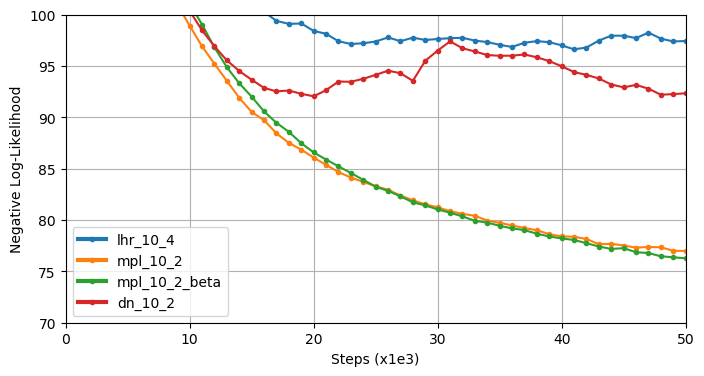

In [190]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0, 50)
plt.ylim(70,100)

plot_banded_error(lhr_10_2, "lhr_10_4")
plot_banded_error(mpl_10_2, "mpl_10_2")
plot_banded_error(mpl_10_2_beta, "mpl_10_2_beta")
plot_banded_error(dn_10_2, "dn_10_2")
#plot_banded_error(mpr_10_2, "mpr_10_2")


fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('foo.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[1]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()